# Crop Images Classification using CNN


In this project, I will train a classifier to recognize different crops. I will use [Agriculture crop images dataset](https://www.kaggle.com/datasets/aman2000jaiswal/agriculture-crop-images) of 5 crops, you can see a few examples below. 

<img src='assets/crops.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the crop classifier on your dataset and perform hyper-parameter tunning
* Use the trained classifier to predict crop

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import torch
import optuna
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from collections import OrderedDict

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load the data

Here I use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The dataset is split into two parts, training and testing. For the training, I apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I also make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The testing sets are used to measure the model's performance on data it hasn't seen yet. For this I don't want any scaling or rotation transformations, but I resize then crop the images to the appropriate size.

The pre-trained networks I will use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [2]:
data_dir = '/data'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

In [3]:
# Define transforms for the training and testing sets
data_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_image_datasets = datasets.ImageFolder(train_dir, transform = data_transforms)
test_image_datasets = datasets.ImageFolder(test_dir, transform = test_transforms)

# Define the dataset size and the desired split ratio (e.g., 80% train, 20% validation)
dataset_size = len(train_image_datasets)
train_ratio = 0.8
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = torch.utils.data.random_split(train_image_datasets, [train_size, val_size])

# Using the image datasets and the trainforms, define the dataloaders
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_image_datasets, batch_size = batch_size)

### Label mapping

In [4]:
# Create a dictionary mapping the integer encoded categories to the actual names of the crops
crop_to_name = {'0': 'jute', '1': 'maize', '2': 'rice', '3': 'sugarcane', '4': 'wheat'}

## Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, I use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features. Things I will do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

In [5]:
# Build and train network

# Use GPU if it's available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Now the deivce is set to {device}')

model = models.vgg19(pretrained = True)
model

Now the deivce is set to cuda:0


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 207MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [6]:
# Freeze parameters so we don't backprop through them
for params in model.parameters():
    params.requries_grad = False


classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 4096)),
                                        ('relu1', nn.ReLU()),
                                        ('drop1', nn.Dropout(p = 0.5)),
                                        ('fc2', nn.Linear(4096, 4096)),
                                        ('relu2', nn.ReLU()),
                                        ('drop2', nn.Dropout(p = 0.5)),
                                        ('fc3', nn.Linear(4096, 5)),
                                        ('output', nn.LogSoftmax(dim = 1))]))


model.classifier = classifier

# Negative Log Likelihood Loss
criterion = nn.NLLLoss()

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Hyper-parameters tunning


In [7]:
epochs = 40
learning_rates = [0.0001, 0.001, 0.01, 0.1]
result = {}
result['learning_rates'] = learning_rates
acc = []

for lr in learning_rates:
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr = lr)
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        running_loss = 0
        for inputs, labels in train_loader:
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)

            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        else:
            val_loss = 0
            accuracy = 0
            with torch.no_grad():                  
                model.eval()
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    val_loss += criterion(logps, labels).item()

                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            model.train()

            train_losses.append(running_loss/len(train_loader))
            val_losses.append(val_loss/len(val_loader))

    print("Learning Rate: {}.. ".format(lr),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Validation Loss: {:.3f}.. ".format(val_losses[-1]),
          "Validation Accuracy: {:.3f}".format(accuracy/len(val_loader)))
    acc.append(accuracy/len(val_loader))

Learning Rate: 0.0001..  Training Loss: 0.189..  Validation Loss: 0.224..  Validation Accuracy: 0.943
Learning Rate: 0.001..  Training Loss: 0.623..  Validation Loss: 0.639..  Validation Accuracy: 0.779
Learning Rate: 0.01..  Training Loss: 26.052..  Validation Loss: 1.372..  Validation Accuracy: 0.360
Learning Rate: 0.1..  Training Loss: 1.795..  Validation Loss: 5.071..  Validation Accuracy: 0.167


In [9]:
result['validation_accuracy'] = acc
best_lr = result['learning_rates'][acc.index(max(acc))]
print("Selected learning rate: " + str(best_lr))

Selected learning rate: 0.0001


### Train the final classifier


Epoch: 1/40..  Training Loss: 1.336.. 
Epoch: 2/40..  Training Loss: 0.902.. 
Epoch: 3/40..  Training Loss: 0.802.. 
Epoch: 4/40..  Training Loss: 0.718.. 
Epoch: 5/40..  Training Loss: 0.595.. 
Epoch: 6/40..  Training Loss: 0.599.. 
Epoch: 7/40..  Training Loss: 0.499.. 
Epoch: 8/40..  Training Loss: 0.532.. 
Epoch: 9/40..  Training Loss: 0.466.. 
Epoch: 10/40..  Training Loss: 0.460.. 
Epoch: 11/40..  Training Loss: 0.426.. 
Epoch: 12/40..  Training Loss: 0.437.. 
Epoch: 13/40..  Training Loss: 0.395.. 
Epoch: 14/40..  Training Loss: 0.413.. 
Epoch: 15/40..  Training Loss: 0.371.. 
Epoch: 16/40..  Training Loss: 0.436.. 
Epoch: 17/40..  Training Loss: 0.363.. 
Epoch: 18/40..  Training Loss: 0.401.. 
Epoch: 19/40..  Training Loss: 0.284.. 
Epoch: 20/40..  Training Loss: 0.390.. 
Epoch: 21/40..  Training Loss: 0.337.. 
Epoch: 22/40..  Training Loss: 0.292.. 
Epoch: 23/40..  Training Loss: 0.380.. 
Epoch: 24/40..  Training Loss: 0.287.. 
Epoch: 25/40..  Training Loss: 0.323.. 
Epoch: 26

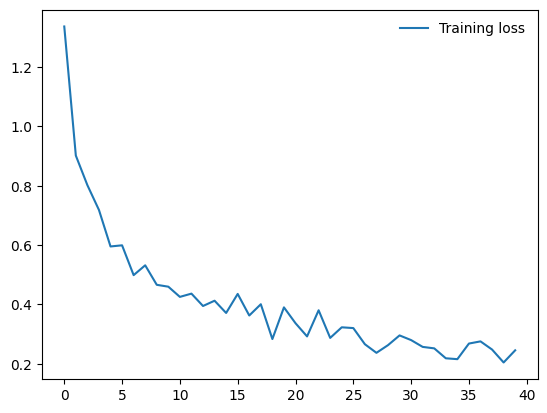

In [10]:
final_model = models.vgg19(pretrained = True)
# Freeze parameters so we don't backprop through them
for params in final_model.parameters():
    params.requries_grad = False


classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 4096)),
                                        ('relu1', nn.ReLU()),
                                        ('drop1', nn.Dropout(p = 0.5)),
                                        ('fc2', nn.Linear(4096, 4096)),
                                        ('relu2', nn.ReLU()),
                                        ('drop2', nn.Dropout(p = 0.5)),
                                        ('fc3', nn.Linear(4096, 5)),
                                        ('output', nn.LogSoftmax(dim = 1))]))


final_model.classifier = classifier

# Negative Log Likelihood Loss
final_criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
final_optimizer = optim.Adam(final_model.classifier.parameters(), lr = best_lr)

final_model.to(device)

final_train_losses = []
for epoch in range(epochs):
    running_loss = 0
    for inputs, labels in train_loader:
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = final_model.forward(inputs)
        loss = final_criterion(logps, labels)
        final_optimizer.zero_grad()
        loss.backward()
        final_optimizer.step()

        running_loss += loss.item()
    final_train_losses.append(running_loss/len(train_loader))
    print("Epoch: {}/{}.. ".format(epoch+1, epochs),
          "Training Loss: {:.3f}.. ".format(final_train_losses[-1]))

plt.plot(final_train_losses, label='Training loss')
plt.legend(frameon=False)   

### Test model on the test set

In [11]:
# Do validation on the test set
final_model.to(device)
test_loss = 0
accuracy = 0
final_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = final_model.forward(inputs)
        batch_loss = criterion(logps, labels)
                    
        test_loss += batch_loss.item()
                    
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
print(f"Test accuracy: {accuracy/len(test_loader):.3f}")

Test accuracy: 0.715


### Save the checkpoint

Now the network is trained, save the model so I can load it later for making predictions. I want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. I can attach this to the model as an attribute which makes inference easier later on.

I want to completely rebuild the model later so I can use it for inference. I include needed information in the checkpoint. I want to load the model and keep training, so I save the number of epochs as well as the optimizer state, `optimizer.state_dict`.

In [12]:
# set a new attr to the model object, which holds the class_to_idx conversion
final_model.class_to_idx = train_image_datasets.class_to_idx
    
# Checkpoint is a dictionary, can be modified to hold anything you need in the furture
checkpoint = {'arch': 'vgg19',
              'class_to_idx': final_model.class_to_idx,
              'model_state_dict': final_model.state_dict(),
              'optimizer_state_dict': final_optimizer.state_dict()}
    
# Save with torch.save
torch.save(checkpoint, 'checkpoint.pth')

### Load the checkpoint

At this point I write a function that can load a checkpoint and rebuild the model. That way I can come back to this project and keep working on it without having to retrain the network.

In [13]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model.class_to_idx = checkpoint['class_to_idx']
    classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 4096)),
                                            ('relu1', nn.ReLU()),
                                            ('drop1', nn.Dropout(p = 0.5)),
                                            ('fc2', nn.Linear(4096, 4096)),
                                            ('relu2', nn.ReLU()),
                                            ('drop2', nn.Dropout(p = 0.5)),
                                            ('fc3', nn.Linear(4096, 5)),
                                            ('output', nn.LogSoftmax(dim = 1))]))
    model.classifier = classifier
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

In [14]:
loaded_model = load_checkpoint('checkpoint.pth')
print(loaded_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Inference for classification

Now I write a function to use a trained network for inference. That is, I will pass an image into the network and predict the class of the crop in the image. The function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It looks like :

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['0', '1', '2', '3', '4']
```

### Image Preprocessing

I use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). I write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, I resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then I crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. I convert the values. It's easiest with a Numpy array.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. I subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. I reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [15]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    pil_image = Image.open(image_path)
    
    # Resize with Aspect Ratio maintained
    # First fixing the short axes
    if pil_image.width > pil_image.height:
        (width, height) = (int(pil_image.width / pil_image.height) * 256, 256)
    else:
        (width, height) = (256, int(pil_image.height / pil_image.width) * 256)
    pil_image = pil_image.resize((width, height))
    
    # Crop
    left = (pil_image.width - 224) / 2
    bottom = (pil_image.height - 224) / 2
    right = left + 224
    top = bottom + 224
    
    pil_image = pil_image.crop((left, bottom, right, top))
    
    # Convert to np then Normalize
    np_image = np.array(pil_image) / 255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # Transpose to fit PyTorch Axes
    np_image = np_image.transpose([2, 0, 1])
    
    return np_image

In [16]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    if title is not None:
        ax.set_title(title)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

### Class Prediction

Once I get images in the correct format, it's time to write a function for making predictions with my model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. I will calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. I convert from these indices to the actual class labels using `class_to_idx` which I added to the model or from an `ImageFolder` I used to load the data ([see here](#Save-the-checkpoint)). I make sure to invert the dictionary so I get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['0', '1', '2', '3', '4']
```

In [17]:
def predict(image_path, model, topk=3):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    img = process_image(image_path)
    
    # Convert np_img to PT tensor and send to GPU
    pt_img = torch.from_numpy(img).type(torch.cuda.FloatTensor)
    
    # Unsqueeze to get shape of tensor from [Ch, H, W] to [Batch, Ch, H, W]
    pt_img = pt_img.unsqueeze(0)

    # Run the model to predict
    output = model.forward(pt_img)
    
    probs = torch.exp(output)
    
    # Pick out the topk from all classes 
    top_probs, top_indices = probs.topk(topk)
    
    # Convert to list on CPU without grads
    top_probs = top_probs.detach().type(torch.FloatTensor).numpy().tolist()[0]
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0]
    
    # Invert the class_to_idx dict to a idx_to_class dict
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    
    top_classname = {idx_to_class[index] for index in top_indices}
    
    return top_probs, top_classname 

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Now the deivce is set to {device}')

Now the deivce is set to cuda:0


In [19]:
loaded_model.to(device)
probs, classes = predict('/data/test/1/maize plant set.jpg', model, 5)   
print(probs)
print(classes)

[1.0, 1.0281089757313566e-08, 2.2842593701971614e-12, 1.2157707837429782e-13, 4.960058497147047e-15]
{'1', '2', '0', '3', '4'}


### Sanity Checking

Now I can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. I use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. I convert from the class integer encoding to actual crop names (loaded earlier in the notebook).

<Axes: title={'center': 'maize'}>

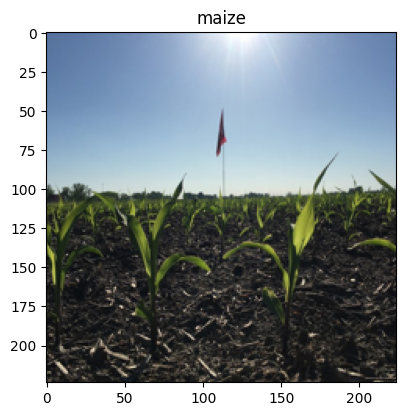

In [21]:
# Display an image along with the top 3 classes
# Plot input image
plt.figure(figsize = (6,10))
plot_1 = plt.subplot(2,1,1)

image = process_image('/data/test/1/maize plant set.jpg')

crop_name = crop_to_name['1']

imshow(image, plot_1, title=crop_name)

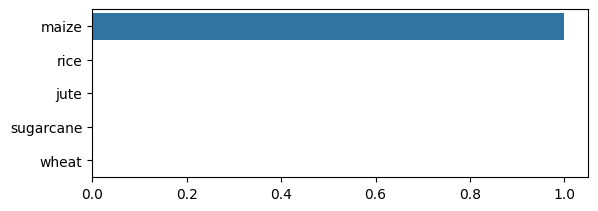

In [22]:
# Convert from the class integer encoding to actual flower names
crop_names = [crop_to_name[i] for i in classes]

# Plot the probabilities for the top 5 classes as a bar graph
plt.subplot(2,1,2)

sb.barplot(x=probs, y=crop_names, color=sb.color_palette()[0]);

plt.show()